In [3]:
import sys

sys.path.append('../GraphStructureLearning')

In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from models.GTS.DCRNN import DCRNN

from torch_geometric.utils import to_dense_adj, dense_to_sparse
from torch_geometric_temporal.dataset import METRLADatasetLoader, PemsBayDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split, StaticGraphTemporalSignalBatch

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from glob import glob
import yaml
from easydict import EasyDict as edict

In [5]:
config_file = glob('./config/GTS/test.yaml')[0]
config = edict(yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader))

In [6]:
metr_la = np.load('./data/METR-LA/node_values.npy')
adj_matrix = np.load('./data/METR-LA/adj_mat.npy')

loader = METRLADatasetLoader(raw_data_dir='./data/METR-LA')

In [9]:
metr_la.shape

(34272, 207, 2)

In [7]:
config.dataset

{'root': './data/spike_lambda_bin100',
 'name': 'spike_lambda_bin100',
 'graph_learning_length': 4800,
 'idx_ratio': 0.5,
 'window_size': 20,
 'slide': 5,
 'pred_step': 5,
 'train_valid_test': [4000, 4400, 4800],
 'save': './data/spike_lambda_bin100/'}

In [8]:
config

{'exp_name': 1,
 'exp_dir': './exp',
 'use_gpu': False,
 'device': 'cpu',
 'seed': 1010,
 'model_name': 'GTS',
 'graph_learning_module': 'GTS',
 'graph_forecasting_module': 'GTS',
 'initial_edge_index': 'Fully Connected',
 'dataset': {'root': './data/spike_lambda_bin100',
  'name': 'spike_lambda_bin100',
  'graph_learning_length': 4800,
  'idx_ratio': 0.5,
  'window_size': 20,
  'slide': 5,
  'pred_step': 5,
  'train_valid_test': [4000, 4400, 4800],
  'save': './data/spike_lambda_bin100/'},
 'train': {'optimizer': 'Adam',
  'epoch': 2,
  'loss_function': 'MAE',
  'lr': 0.001,
  'momentum': 0.9,
  'wd': 0.0,
  'batch_size': 2,
  'lr_decay': 0.1,
  'lr_decay_steps': [10000]},
 'nodes_num': 100,
 'node_features': 1,
 'hidden_dim': 16,
 'embedding_dim': 16,
 'graph_learning': {'sequence': 3,
  'mode': 'attention',
  'to_symmetric': True,
  'correlation_act_fnc': 'sigmoid',
  'kernel_size': [200, 80, 10],
  'stride': [20, 10, 5],
  'conv1_dim': 4,
  'conv2_dim': 4,
  'conv3_dim': 4,
  'n_he

In [64]:
config.hidden_dim = 16
config.encoder_step = 12
config.decoder_step = 3
config.dataset.pred_step = 1
config.embedding_dim = 1
config.nodes_num = 207

In [65]:
total_length, num_nudes, num_features = metr_la.shape

In [66]:
edge_index, edge_attr = dense_to_sparse(torch.Tensor(adj_matrix))

In [68]:
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=3)

In [31]:
_, dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [60]:
dataset

In [59]:
StaticGraphTemporalSignalBatch()

TypeError: __init__() missing 4 required positional arguments: 'edge_weight', 'features', 'targets', and 'batches'

In [32]:
class DecoderModel(nn.Module):
    def __init__(self, config):
        super(DecoderModel, self).__init__()
        self.output_dim = config.dataset.pred_step
        self.hidden_dim = config.hidden_dim

        self.decoder_dcrnn = DCRNN(config)
        self.prediction_layer = nn.Linear(self.hidden_dim, self.output_dim)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.fill_(0.1)

    def forward(self, inputs, adj, hidden_state, weight_matrix=None):
        decoder_hidden_state = hidden_state

        decoder_hidden_state = self.decoder_dcrnn(inputs, adj, hidden_state=decoder_hidden_state, weight_matrix=weight_matrix)
        prediction = self.prediction_layer(decoder_hidden_state[-1].view(-1, self.hidden_dim))

        output = prediction.view(inputs.shape[0], self.output_dim)

        return output, decoder_hidden_state


class GTS_Forecasting_Module(nn.Module):
    def __init__(self, config):
        super(GTS_Forecasting_Module, self).__init__()

        self.config = config

        self.nodes_num = config.nodes_num

        self.nodes_feas = config.node_features

        self.encoder_step = config.encoder_step
        self.decoder_step = config.decoder_step

        self.encoder_model = DCRNN(config)
        self.decoder_model = DecoderModel(config)


    def forward(self, inputs, targets, adj_matrix, weight_matrix=None):
        # DCRNN encoder
        encoder_hidden_state = None
        for i in range(self.encoder_step):
            encoder_hidden_state = self.encoder_model(inputs[:,i].unsqueeze(dim=-1), adj_matrix,
                                                      encoder_hidden_state, weight_matrix)

        # DCRNN decoder
        outputs = []
        decoder_input = torch.zeros((self.nodes_num, 1)).to('cuda')
        
        decoder_hidden_state = encoder_hidden_state
        for j in range(self.decoder_step):
            output, decoder_hidden_state = self.decoder_model(decoder_input, adj_matrix, decoder_hidden_state, weight_matrix)
            outputs.append(output)
            
            decoder_input = targets[:,j].unsqueeze(dim=-1)

        outputs = torch.cat(outputs, dim=-1)
        return outputs


In [33]:
model = GTS_Forecasting_Module(config)

In [34]:
model = model.to('cuda')

In [35]:
model

GTS_Forecasting_Module(
  (encoder_model): DCRNN(
    (recurrent): ModuleList(
      (0): DCRNN(
        (conv_x_z): DConv()
        (conv_x_r): DConv()
        (conv_x_h): DConv()
      )
    )
  )
  (decoder_model): DecoderModel(
    (decoder_dcrnn): DCRNN(
      (recurrent): ModuleList(
        (0): DCRNN(
          (conv_x_z): DConv()
          (conv_x_r): DConv()
          (conv_x_h): DConv()
        )
      )
    )
    (prediction_layer): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fnc = nn.L1Loss().to('cuda')
model.train()

GTS_Forecasting_Module(
  (encoder_model): DCRNN(
    (recurrent): ModuleList(
      (0): DCRNN(
        (conv_x_z): DConv()
        (conv_x_r): DConv()
        (conv_x_h): DConv()
      )
    )
  )
  (decoder_model): DecoderModel(
    (decoder_dcrnn): DCRNN(
      (recurrent): ModuleList(
        (0): DCRNN(
          (conv_x_z): DConv()
          (conv_x_r): DConv()
          (conv_x_h): DConv()
        )
      )
    )
    (prediction_layer): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [37]:
for epoch in range(2):
    loss = 0
    
    for batch in dataset:
        input_x = batch.x[:,0,:].to('cuda')
        target = batch.y.to('cuda')
    
        y_hat = model(input_x, adj_matrix = batch.edge_index.to('cuda'), targets=target)
        loss = loss + loss_fnc(y_hat, target)

In [38]:
loss

tensor(5715.9536, device='cuda:0', grad_fn=<AddBackward0>)

In [40]:
y_hat.shape

torch.Size([207, 3])

In [41]:
target.shape

torch.Size([207, 3])

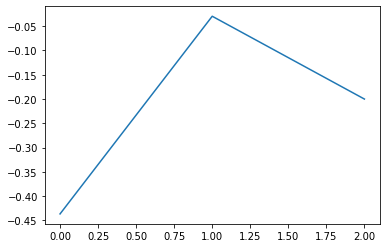

In [50]:
plt.plot(target[5,:].cpu())

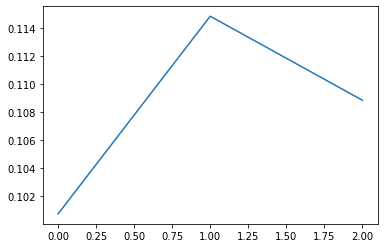

In [51]:
plt.plot(y_hat[5,:].detach().cpu())

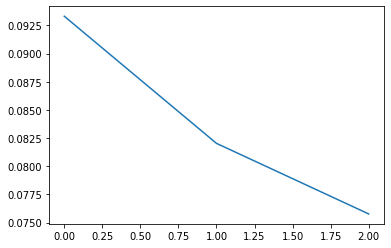

In [47]:
plt.plot(y_hat[100,:].detach().cpu())

In [48]:
y_hat

tensor([[0.0927, 0.0709, 0.0617],
        [0.0907, 0.0812, 0.0739],
        [0.0896, 0.0636, 0.0585],
        [0.0937, 0.0818, 0.0792],
        [0.1344, 0.2044, 0.2378],
        [0.1007, 0.1149, 0.1089],
        [0.0932, 0.0760, 0.0685],
        [0.0912, 0.0747, 0.0675],
        [0.0931, 0.0832, 0.0777],
        [0.0904, 0.0842, 0.0686],
        [0.0934, 0.0757, 0.0732],
        [0.0923, 0.0742, 0.0663],
        [0.0929, 0.0752, 0.0670],
        [0.0904, 0.0696, 0.0671],
        [0.0963, 0.0925, 0.1128],
        [0.0923, 0.0837, 0.0698],
        [0.1344, 0.2044, 0.2378],
        [0.0917, 0.0740, 0.0702],
        [0.1046, 0.1067, 0.1050],
        [0.0927, 0.0775, 0.0681],
        [0.0902, 0.0690, 0.0603],
        [0.1013, 0.0963, 0.1020],
        [0.1005, 0.1005, 0.1048],
        [0.0959, 0.0833, 0.0867],
        [0.0931, 0.0718, 0.0594],
        [0.0950, 0.0868, 0.0771],
        [0.0951, 0.0866, 0.0827],
        [0.0934, 0.0774, 0.0734],
        [0.0896, 0.0702, 0.0557],
        [0.090

In [49]:
target

tensor([[ 6.6306e-01,  6.5069e-01,  5.6960e-01],
        [ 3.0020e-01,  4.2803e-01,  6.5756e-01],
        [ 7.8951e-01,  6.1358e-01,  6.5206e-01],
        [ 3.6617e-01,  2.9814e-01,  3.7717e-01],
        [-2.6522e+00, -2.6522e+00, -2.6522e+00],
        [-4.3651e-01, -2.9672e-02, -2.0011e-01],
        [ 5.2561e-01,  5.2875e-01,  6.0258e-01],
        [ 5.0362e-01,  5.2080e-01,  5.6960e-01],
        [ 3.0570e-01,  3.5999e-01,  4.6514e-01],
        [ 2.0124e-01,  6.2595e-01,  3.9916e-01],
        [ 5.3661e-01,  3.8473e-01,  3.7167e-01],
        [ 5.4760e-01,  5.5791e-01,  5.4760e-01],
        [ 5.3661e-01,  5.5791e-01,  5.3111e-01],
        [ 6.3557e-01,  4.5277e-01,  6.6856e-01],
        [ 1.0777e-01, -5.4922e-01,  5.8059e-01],
        [ 2.6721e-01,  5.9502e-01,  6.0808e-01],
        [-2.6522e+00, -2.6522e+00, -2.6522e+00],
        [ 5.3661e-01,  4.3421e-01,  5.6960e-01],
        [-6.8157e-02, -1.1117e-02,  5.8294e-02],
        [ 4.6514e-01,  5.5791e-01,  4.4314e-01],
        [ 6.4657e-01